<a href="https://colab.research.google.com/github/llwusill/PlateDetection/blob/main/Plate_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q datasets jiwer

In [ ]:
!mkdir output

mkdir: cannot create directory ‘output’: File exists


In [ ]:
import os
import time
import numpy as np
import pandas as pd

import cv2
import json
from PIL import Image

output_dir = '/content/output'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
from bs4 import BeautifulSoup

def get_string(file):

    with open(file, 'r') as f:
        data = f.read()

    bs_data = BeautifulSoup(data, 'xml')

    b_unique = bs_data.find_all('object')
    return ''.join([i.find('name').text for i in b_unique])

def yolo_to_abs(data_dict):#, scale=100.0):
    cord = {}

    original_width = data_dict['original_width']
    original_height = data_dict['original_height']

    pixel_x = int(data_dict['x']/100. * original_width)
    pixel_y = int(data_dict['y']/100. * original_height)
    pixel_width = int(data_dict['width']/100. * original_width)
    pixel_height = int(data_dict['height']/100. * original_height)

    cord['x1'] = pixel_x -2#- pixel_width #/2)*original_width
    cord['y1'] = pixel_y -2#- pixel_height#/2)*original_height
    cord['x2'] = pixel_x + pixel_width +5 #/2)*original_width
    cord['y2'] = pixel_y + pixel_height + 5#/2)*original_height
    return cord

In [ ]:
def preprocess(image, width: int, height: int, cval: int = 255, mode="letterbox", return_scale=False,):
    fitted = None
    x_scale = width / image.shape[1]
    y_scale = height / image.shape[0]
    if x_scale == 1 and y_scale == 1:
        fitted = image
        scale = 1
    elif (x_scale <= y_scale and mode == "letterbox") or (
        x_scale >= y_scale and mode == "crop"
    ):
        scale = width / image.shape[1]
        resize_width = width
        resize_height = (width / image.shape[1]) * image.shape[0]
    else:
        scale = height / image.shape[0]
        resize_height = height
        resize_width = scale * image.shape[1]
    if fitted is None:
        resize_width, resize_height = map(int, [resize_width, resize_height])
        if mode == "letterbox":
            fitted = np.zeros((height, width, 3), dtype="uint8") + cval
            image = cv2.resize(image, dsize=(resize_width, resize_height))
            fitted[: image.shape[0], : image.shape[1]] = image[:height, :width]
        elif mode == "crop":
            image = cv2.resize(image, dsize=(resize_width, resize_height))
            fitted = image[:height, :width]
        else:
            raise NotImplementedError(f"Unsupported mode: {mode}")
    if not return_scale:
        return fitted
    return fitted, scale

###Adım 1

Plakadaki karakterleri algılama

In [ ]:
image_dir = '/content/drive/MyDrive/Plate_System_trOCR/OCR_LP/LP-characters/images'
annotations_dir = '/content/drive/MyDrive/Plate_System_trOCR/OCR_LP/LP-characters/annotations'

lic_record = []

for im_name in sorted(os.listdir(image_dir)):
    image_path = os.path.join(image_dir, im_name)

    annot_path = os.path.join(annotations_dir, im_name.split('.')[0]+'.xml')
    label_string = get_string(annot_path)

    lic_record.append(dict(text=str(label_string), file_name=image_path))


In [ ]:
df1 = pd.DataFrame(lic_record)
df1.to_csv('/content/output/lic_labels1.csv')

df1.head()


text                                          file_name
0   MH15TC554  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
1  MH02CB4545  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
2    KA031351  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
3   TN0600000  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
4  KA51MJ8156  /content/drive/MyDrive/Plate_System_trOCR/OCR_...

In [ ]:
df1

text                                          file_name
0     MH15TC554  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
1    MH02CB4545  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
2      KA031351  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
3     TN0600000  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
4    KA51MJ8156  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
..          ...                                                ...
204  MH2OBN3525  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
205  MH01AR5274  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
206  MH20CS1941  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
207   H20CS1938  /content/drive/MyDrive/Plate_System_trOCR/OCR_...
208  MH14DT8831  /content/drive/MyDrive/Plate_System_trOCR/OCR_...

[209 rows x 2 columns]

###Adım 2
* Plaka tanıma sistemi dataseti

In [ ]:
license_no_data = pd.read_csv('/content/drive/MyDrive/Plate_System_trOCR/ocr-licence-plate.csv')
# license_no_data = license_no_data.sample(frac = 1)
license_no_data['ocr'] = license_no_data['ocr'].apply(lambda x: x.split('-')[-1])

license_no_data

ocr   id                                               bbox  \
0    Cars430.png  431  [{"x": 11.066398390342053, "y": 72.5, "width":...   
1    Cars429.png  430  [{"x": 32.62032085561498, "y": 41.851106639839...   
2    Cars427.png  428  [{"x": 41.04627766599598, "y": 43.699731903485...   
3    Cars426.png  427  [{"x": 41.85110663983904, "y": 68.632707774798...   
4    Cars425.png  426  [{"x": 42.45472837022133, "y": 46.320346320346...   
..           ...  ...                                                ...   
309    Cars4.png    5  [{"x": 26.559356136820927, "y": 25.42372881355...   
310    Cars3.png    4  [{"x": 35.2112676056338, "y": 55.7142857142857...   
311    Cars2.png    3  [{"x": 57.29972246043483, "y": 43.923670974270...   
312    Cars1.png    2  [{"x": 34.390806447042095, "y": 51.59992211332...   
313    Cars0.png    1  [{"x": 46.37096774193548, "y": 46.992481203007...   

                                                 label  transcription  \
0    [{"x": 11.066398390342053, "y": 72.5, "width":...        BCG-986   
1    [{"x": 32.62032085561498, "y": 41.851106639839...         KA1SER   
2    [{"x": 41.04627766599598, "y": 43.699731903485...  01 CC 1A 0001   
3    [{"x": 41.85110663983904, "y": 68.632707774798...          CRAIG   
4    [{"x": 42.45472837022133, "y": 46.320346320346...        G526JHD   
..                                                 ...            ...   
309  [{"x": 26.559356136820927, "y": 25.42372881355...        PUI8BES   
310  [{"x": 35.2112676056338, "y": 55.7142857142857...        DZI7YXR   
311  [{"x": 57.29972246043483, "y": 43.923670974270...        PRE-NUP   
312  [{"x": 34.390806447042095, "y": 51.59992211332...       PG-MN112   
313  [{"x": 46.37096774193548, "y": 46.992481203007...     KL01CA2555   

     annotator  annotation_id                   created_at  \
0            1            314  2023-03-09T11:29:21.270803Z   
1            1            313  2023-03-09T11:29:07.437858Z   
2            1            312  2023-03-09T11:28:48.305793Z   
3            1            311  2023-03-09T11:28:30.687784Z   
4            1            310  2023-03-09T11:28:14.569265Z   
..         ...            ...                          ...   
309          1              5  2023-03-09T07:34:52.009265Z   
310          1              4  2023-03-09T07:34:25.449170Z   
311          1              3  2023-03-09T07:34:08.941012Z   
312          1              2  2023-03-09T07:27:38.964069Z   
313          1              1  2023-03-09T07:26:48.516744Z   

                      updated_at  lead_time  
0    2023-03-09T11:29:21.270849Z     11.090  
1    2023-03-09T11:29:07.437904Z     13.608  
2    2023-03-09T11:28:48.305844Z     13.518  
3    2023-03-09T11:28:30.687842Z     13.059  
4    2023-03-09T11:28:14.569302Z     20.648  
..                           ...        ...  
309  2023-03-09T07:34:52.009298Z     24.077  
310  2023-03-09T07:34:25.449216Z     13.863  
311  2023-03-09T07:34:08.941056Z     17.317  
312  2023-03-09T07:27:38.964130Z     45.524  
313  2023-03-09T07:26:48.516788Z     23.025  

[314 rows x 10 columns]

In [ ]:
lic_record = []
path_car_img = "/content/drive/MyDrive/Plate_System_trOCR/archive/images"
os.makedirs("/content/output/images/", exist_ok=True)
for row, val in  license_no_data.iterrows():                         # need improvement
    img_dir = os.path.join(path_car_img, val['ocr'])
    image = cv2.imread(img_dir, cv2.IMREAD_ANYCOLOR)
    try:
        label_s = json.loads(val['transcription'])
    except ValueError:
        label_s = str(val['transcription'])
    for num, bbox in enumerate(json.loads(val['bbox'])):
        path_to_save = f"/content/output/images/{val['ocr'].split('.')[0]}_{num}.jpg"

        cart_cord = yolo_to_abs(bbox)
        crop_img = image[cart_cord['y1']:cart_cord['y2'],
                         cart_cord['x1']:cart_cord['x2']]
        crop_img = preprocess(crop_img, width=200, height=100)

#         process_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY) #.astype("float32")[..., np.newaxis]
        im_croped = Image.fromarray(crop_img)

        im_croped.save(path_to_save)
        if isinstance(label_s, list):
            lic_record.append( dict(text=str(label_s[num]), file_name=path_to_save))
        else:
            lic_record.append(dict(text=str(label_s), file_name = path_to_save))

In [ ]:
df2 = pd.DataFrame(lic_record)
df2.to_csv('/content/output/lic_labels.csv')
df2.sort_values('file_name', inplace=True)
df2

text                             file_name
339  KL01CA2555    /content/output/images/Cars0_0.jpg
243    WW 95550  /content/output/images/Cars100_0.jpg
242   68-611-36  /content/output/images/Cars102_0.jpg
241     NL60LXB  /content/output/images/Cars104_0.jpg
240       J966S  /content/output/images/Cars105_0.jpg
..          ...                                   ...
247  KA05MG1909   /content/output/images/Cars97_0.jpg
246      YWORRY   /content/output/images/Cars98_0.jpg
244        2662   /content/output/images/Cars99_0.jpg
245       KA-09   /content/output/images/Cars99_1.jpg
331  MH01AV8866    /content/output/images/Cars9_0.jpg

[340 rows x 2 columns]

### Mixing datasets

In [ ]:
from sklearn.model_selection import train_test_split

test_df = pd.concat([df1[-21:],df2[-21:]])
df = pd.concat([df1[:-21], df2[:-21]])
# train_df, valid_df = train_test_split(df[:-21], test_size=0.2)
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=0)

# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
print(df1.shape, df2.shape)
print(train_df.shape, valid_df.shape,test_df.shape)

(209, 2) (340, 2)
(405, 2) (102, 2) (42, 2)


### Download/Load Model

In [ ]:
!pip install easyocr

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# If you want to start from the pretrained model, load the checkpoint with `VisionEncoderDecoderModel`
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')

# TrOCR is a decoder model and should be used within a VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and 

In [ ]:
import torch
from torch.utils.data import Dataset

class LPDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(
            text, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

    def __iter__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

In [ ]:
root_dir = ''

train_dataset = LPDataset(root_dir, df=train_df, processor=processor)

test_dataset = LPDataset(root_dir, df=test_df, processor=processor)

eval_dataset = LPDataset(root_dir, df=valid_df, processor=processor)

In [ ]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-19-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
!pip install accelerate -U

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
#     fp16=True,
    overwrite_output_dir=True,
    output_dir=output_dir,
    logging_steps=2,
    save_steps=500,
    eval_steps=200,
    report_to="none",
    num_train_epochs=3,
)


# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [ ]:
train_time = time.time() ## in UTC time
trainer.train()
train_time = time.time() - train_time

print('Train time (sec)', train_time)

Train time (sec) 256.52362632751465


In [ ]:
save_time = time.time()
model.save_pretrained("/content/output/vit-ocr")
save_time = time.time() - save_time
print('save_time time (sec)', save_time)

Removed shared tensor {'decoder.output_projection.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


save_time time (sec) 7.465670585632324


In [ ]:
score_model = VisionEncoderDecoderModel.from_pretrained('/content/output/vit-ocr')
print(score_model)

###Çıkarımlar

In [ ]:
file_image = '/content/drive/MyDrive/Plate_System_trOCR/OCR_LP/LP-characters/images/0054.png'
image = Image.open(file_image).convert("RGB")
score_time = time.time()

pixel_values = processor(image, return_tensors="pt").pixel_values
# text = "industry, ' Mr. Brown commented icily. ' Let us have a"
# if torch.cuda.is_available():
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pixel_values = pixel_values.to(device)
# # inference
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

score_time = time.time() - score_time
print('score_time (sec)', score_time)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


MH20EE7598
score_time (sec) 0.604203462600708


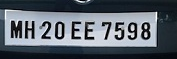

In [ ]:
image

In [ ]:
pixel_values.shape

torch.Size([1, 3, 384, 384])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

def compare_string(true_label, pred_label):

    true_label = true_label.replace(" ", "").replace('-','').replace('0','O')
    pred_label =  pred_label.replace(" ", "").replace('-','').replace('0','O')

    if pred_label == true_label:
        return True

    return False

In [ ]:
correct_char = 0
total_char = 0
correct = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for _, val  in test_df.iterrows():

    image = Image.open(val['file_name']).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    pred_label = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    true_label = val['text']

    correct_char += SequenceMatcher(None, true_label, pred_label).ratio()

    if compare_string(true_label, pred_label) :
        correct += 1
    else:
        plt.imshow(np.asarray(image))
        plt.show()
        print('true_label',true_label)
        print('pred_label',pred_label)

In [ ]:
print(f'correct {correct}, total {len(test_df)}')
print('performance on test  data')
print('Correct characters predicted : %.2f%%' %(correct_char*100/test_df.shape[0]))
print('Correct words predicted      : %.2f%%' %(correct*100/test_df.shape[0]))

correct 26, total 42
performance on test  data
Correct characters predicted : 90.12%
Correct words predicted      : 61.90%


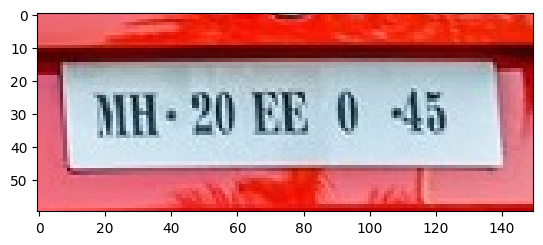

true_label MH20EE045
pred_label MIH:2OEE45


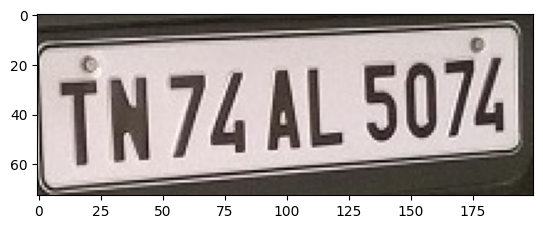

true_label TN74A5L074
pred_label TNZLAL5O74


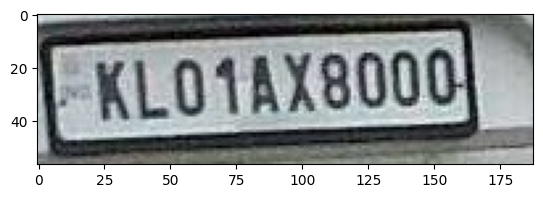

true_label KL01AX8000
pred_label KLoAxeooo


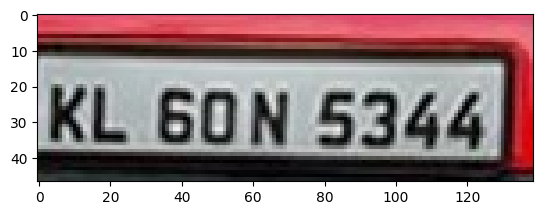

true_label KL60N5344
pred_label KLGON5344


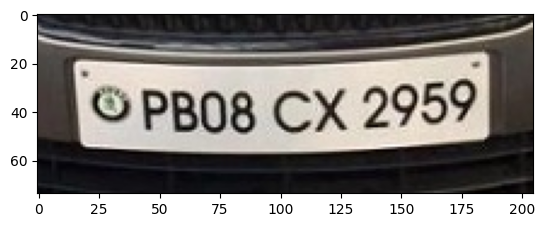

true_label PB08CX2959
pred_label PBO8CX2959]


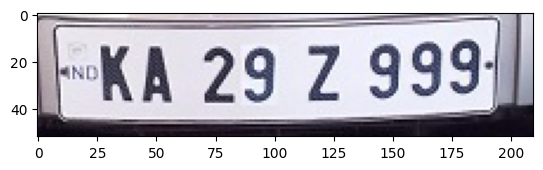

true_label AA29Z999
pred_label FKA292999]


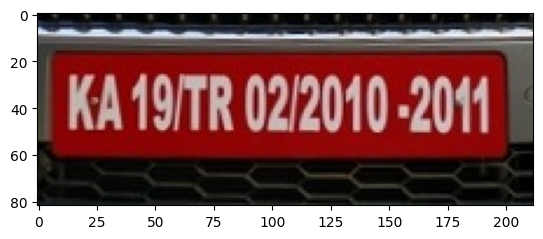

true_label KA19TR0220102011
pred_label KA19FRO212O1O*2O11


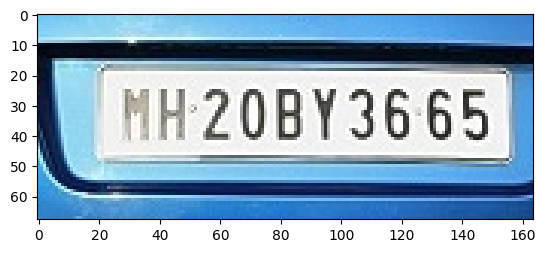

true_label MH20BY3665
pred_label MHZOBY3665


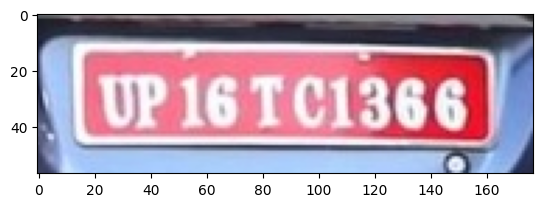

true_label UP16TC1366
pred_label WP16IC1366


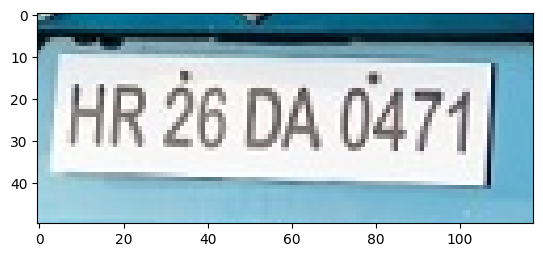

true_label HR26DA0471
pred_label HR26DAO4711


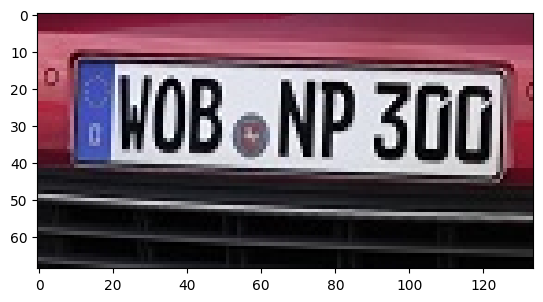

true_label WOBNP300
pred_label MBoNpzod


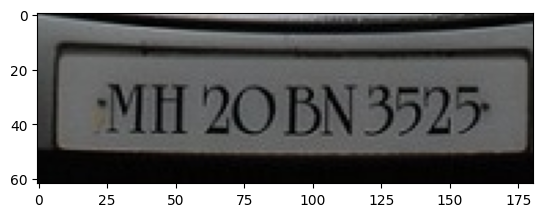

true_label MH2OBN3525
pred_label MMHQ2OBN3525


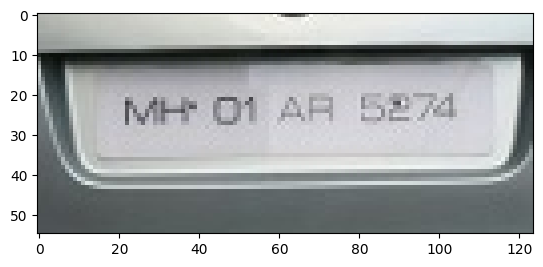

true_label MH01AR5274
pred_label MFOiAA5274


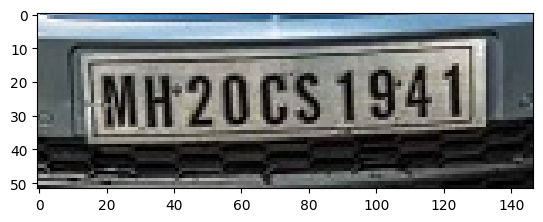

true_label MH20CS1941
pred_label M#2Ocs1941


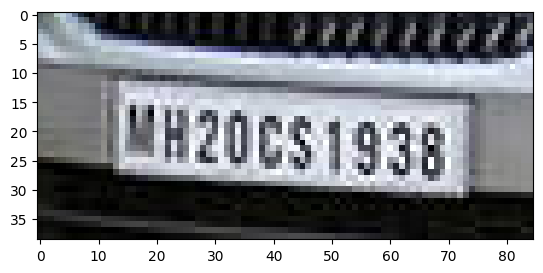

true_label H20CS1938
pred_label Lh2OCs1938


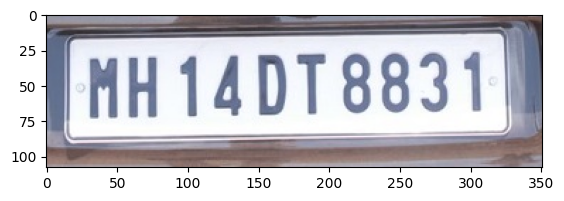

true_label MH14DT8831
pred_label HH14DT8831


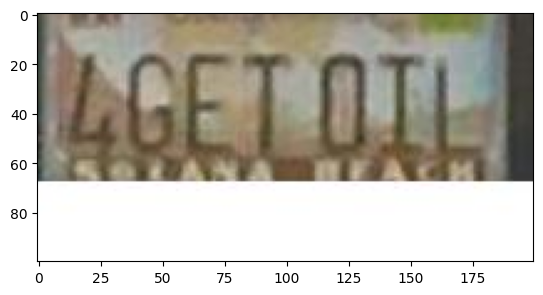

true_label 4GETOIL
pred_label LGETOIL


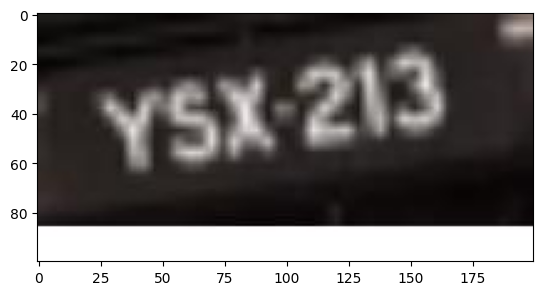

true_label YSX-213
pred_label 213YSY


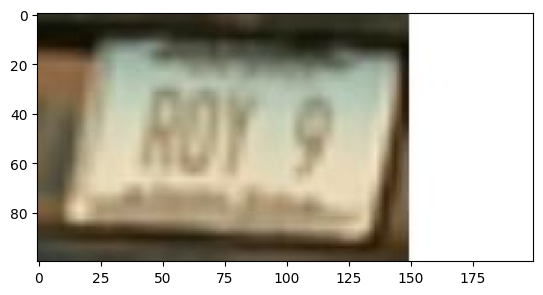

true_label ROY 9
pred_label Rol5


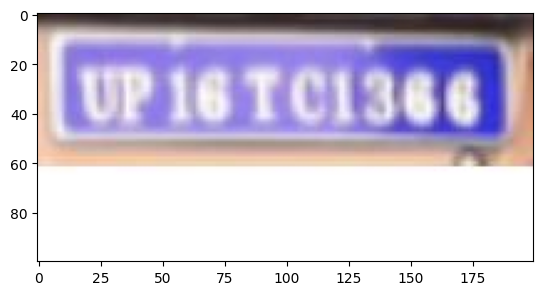

true_label UP16TC1366
pred_label UI6ICIJeC


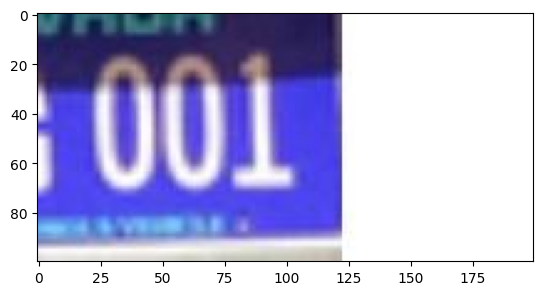

true_label 001
pred_label OOi


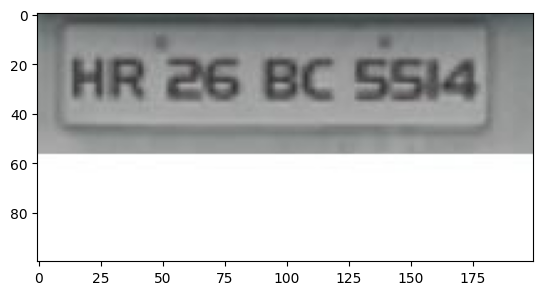

true_label HR26 BC 5514
pred_label 26BC5514HR


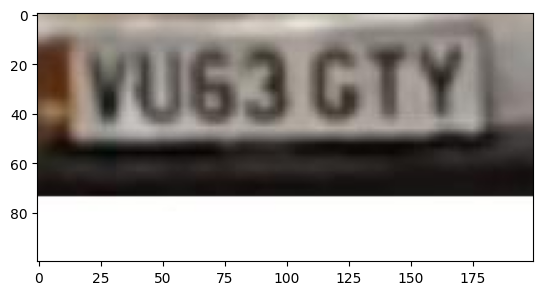

true_label VU63GTY
pred_label Nu63GLY


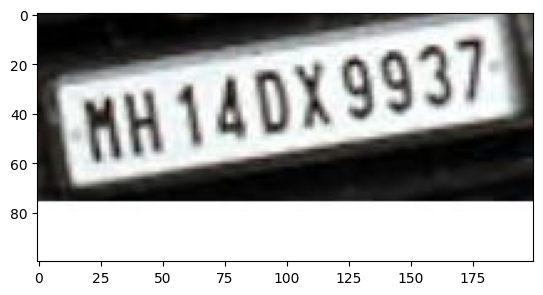

true_label MH14DX9937
pred_label HhM14dX9937/


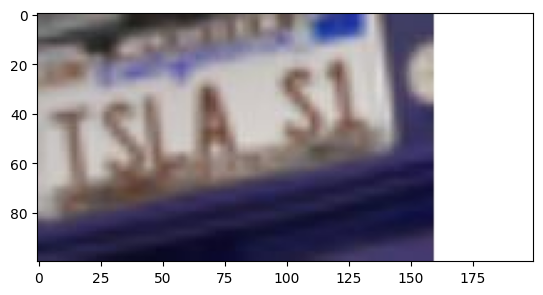

true_label TSLA S1
pred_label Fas


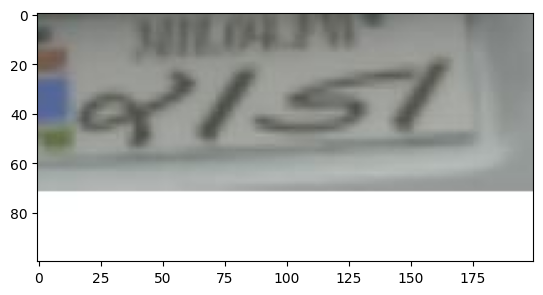

true_label A151
pred_label ela


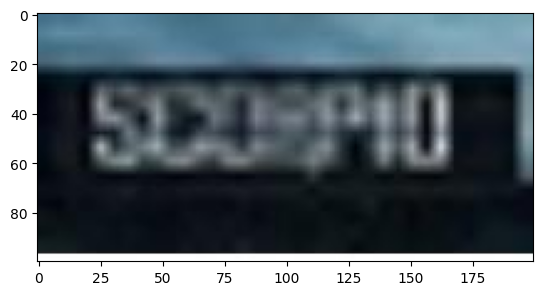

true_label SCORPIO
pred_label Euiew


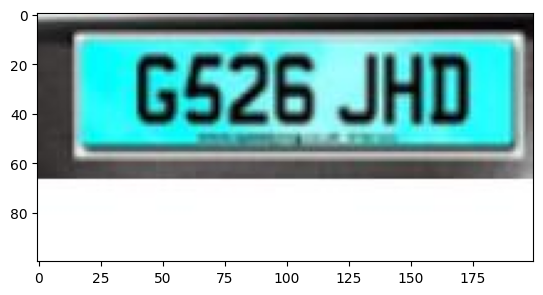

true_label G526JHD
pred_label 6526JHD


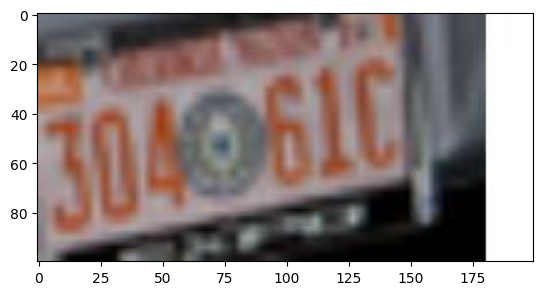

true_label 304-61C
pred_label Jul


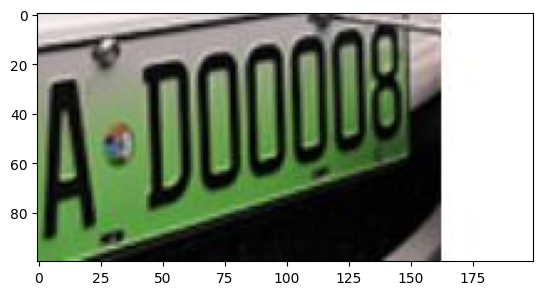

true_label A-D00008
pred_label ADOOOOB


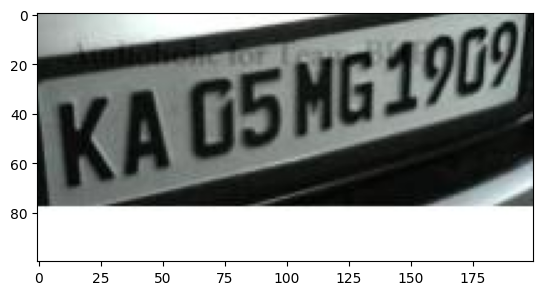

true_label KA05MG1909
pred_label KAO5OG19O9


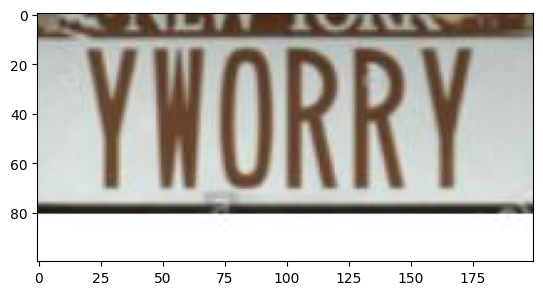

true_label YWORRY
pred_label MUORRY


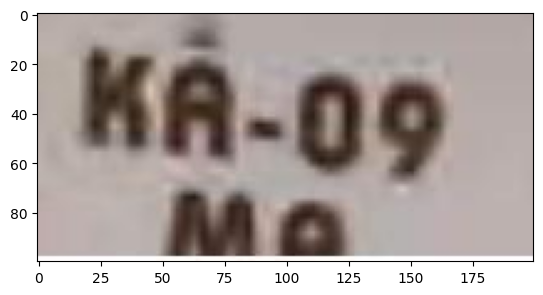

true_label KA-09
pred_label KaO9Ma


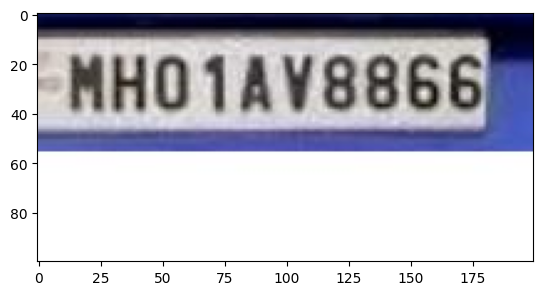

true_label MH01AV8866
pred_label MHO14v8866


In [ ]:
import easyocr
import matplotlib.pyplot as plt
import numpy as np
from difflib import SequenceMatcher
from PIL import Image

correct_char = 0
total_char = 0
correct = 0

reader = easyocr.Reader(['en'])

for _, val  in test_df.iterrows():

    image = Image.open(val['file_name']).convert("RGB")
    image = np.array(image)
    text = reader.readtext(image, detail=0)
    pred_label = ' '.join(text)
    pred_label = pred_label.replace(" ", "").replace('-','-').replace('0','O')

    true_label = val['text']

    correct_char += SequenceMatcher(None, true_label, pred_label).ratio()
    total_char += len(true_label)

    if compare_string(true_label, pred_label) :
        correct += 1
    else:
        plt.imshow(np.asarray(image))
        plt.show()
        print('true_label',true_label)
        print('pred_label',pred_label)

In [ ]:
print(f'correct {correct}, total {len(test_df)}')
print('performance on test  data')
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/len(test_df)))

correct 8, total 42
performance on test  data
Correct characters predicted : 7.19%
Correct words predicted      : 19.05%


###Result's on Data Set

In [ ]:
!pip install pytesseract
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (7,392 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121654 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

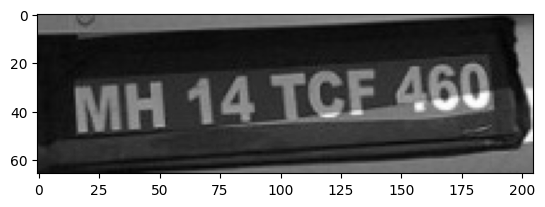

true_label: MH14TCF460
pred_label: 

PiresS



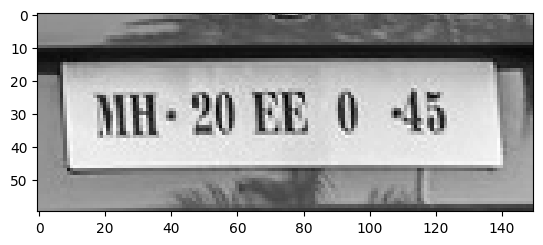

true_label: MH20EE045
pred_label: 



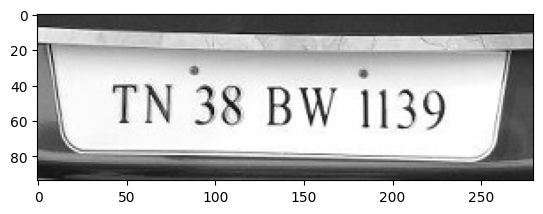

true_label: TN38BW1139
pred_label: TN38BW1139





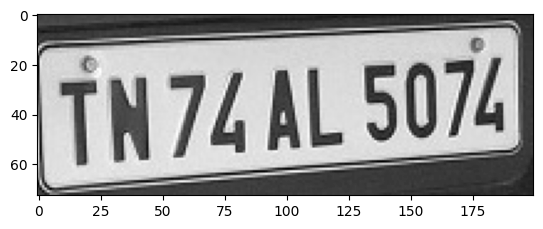

true_label: TN74A5L074
pred_label: 



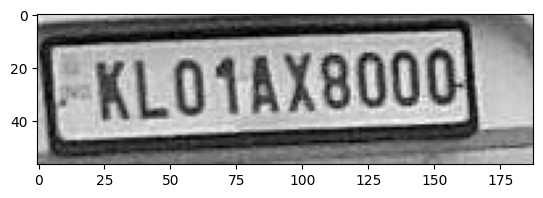

true_label: KL01AX8000
pred_label: 



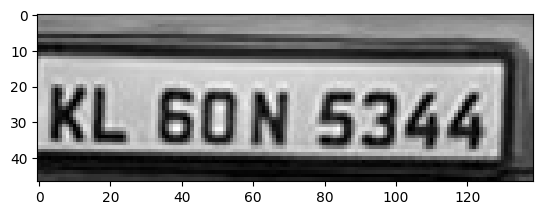

true_label: KL60N5344
pred_label: KL6ON5344)



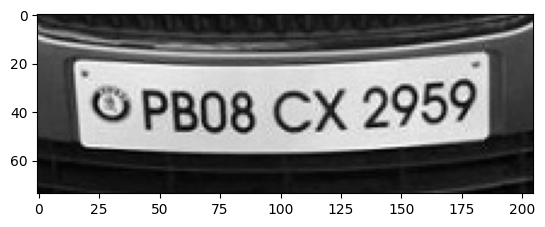

true_label: PB08CX2959
pred_label: 



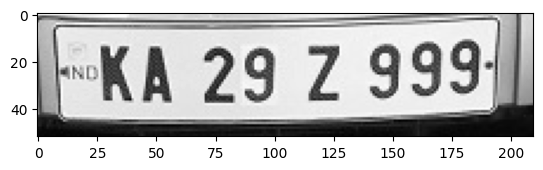

true_label: AA29Z999
pred_label: KA29Z9994



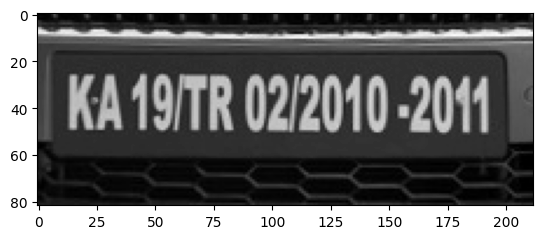

true_label: KA19TR0220102011
pred_label: TOE



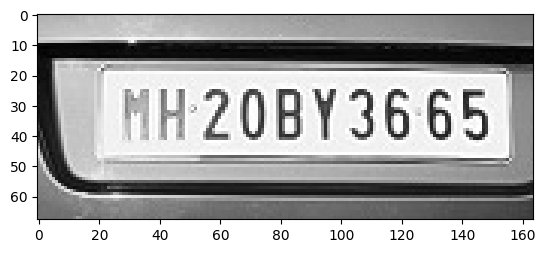

true_label: MH20BY3665
pred_label: 2O873655)



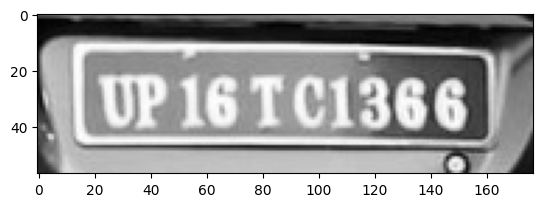

true_label: UP16TC1366
pred_label: 


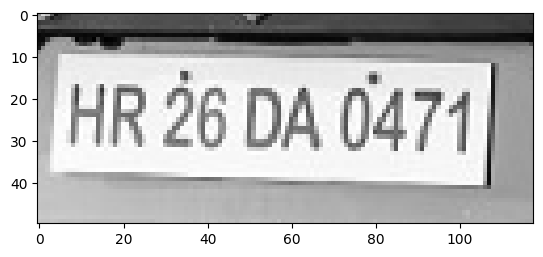

true_label: HR26DA0471
pred_label: 



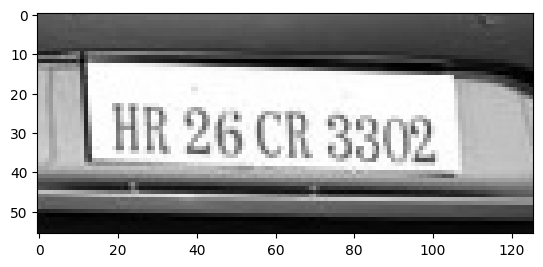

true_label: HR26CR3302
pred_label: 



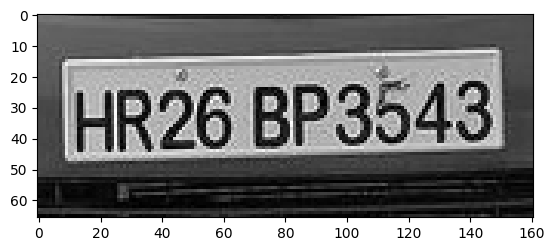

true_label: HR26BP3543
pred_label: HR26BP3543



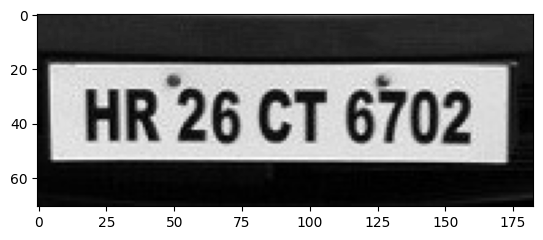

true_label: HR26CT6702
pred_label: HR26CT67O2



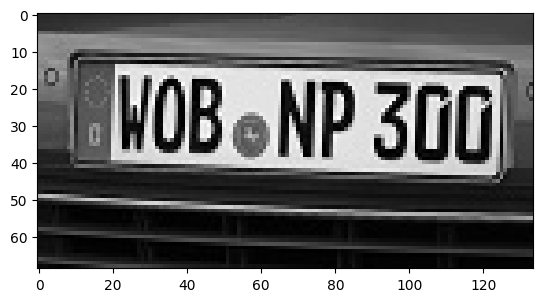

true_label: WOBNP300
pred_label: FosNP3OO)



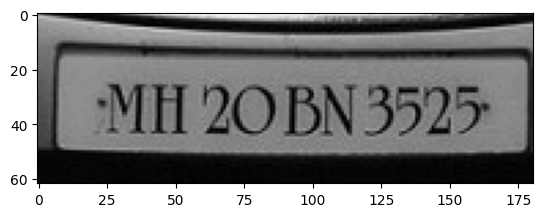

true_label: MH2OBN3525
pred_label: MH2OBN3525



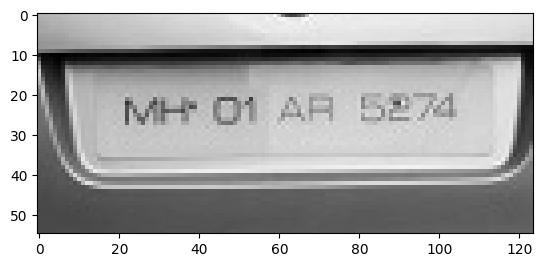

true_label: MH01AR5274
pred_label: 


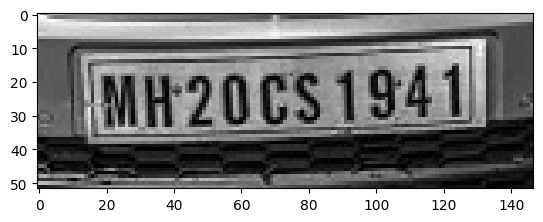

true_label: MH20CS1941
pred_label: 



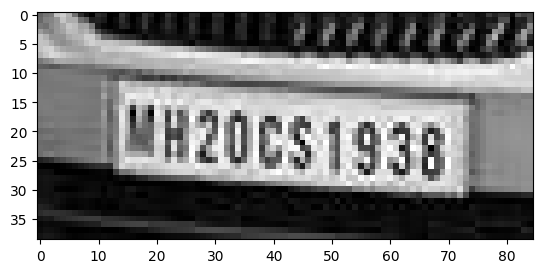

true_label: H20CS1938
pred_label: 

(Om





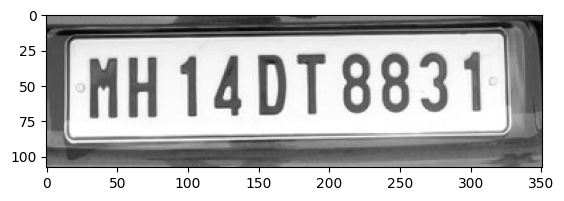

true_label: MH14DT8831
pred_label: MH14DT8831|



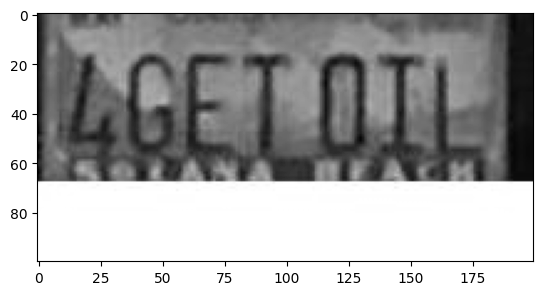

true_label: 4GETOIL
pred_label: 


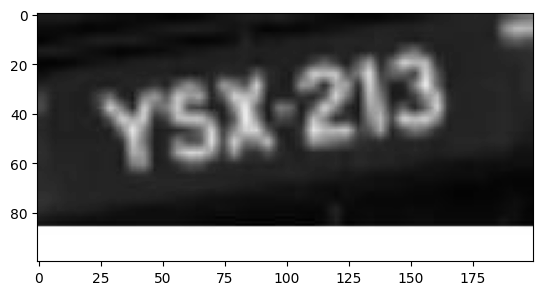

true_label: YSX-213
pred_label: ae



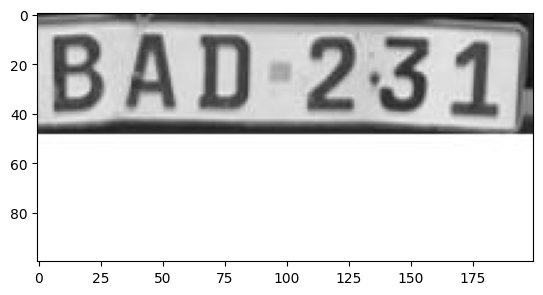

true_label: BAD-231
pred_label: BAD231!



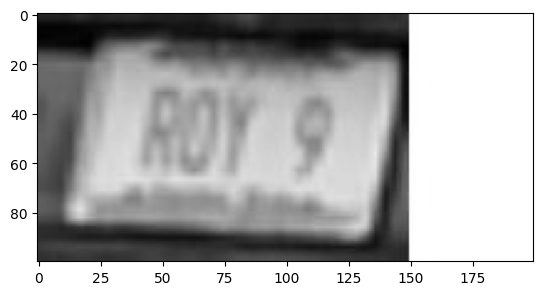

true_label: ROY 9
pred_label: 


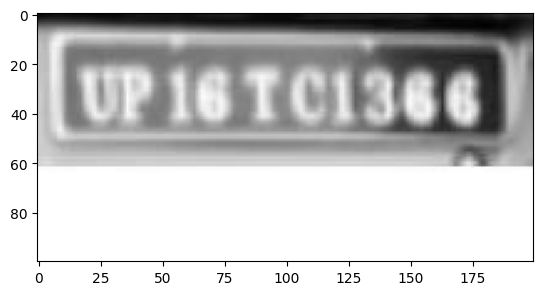

true_label: UP16TC1366
pred_label: 


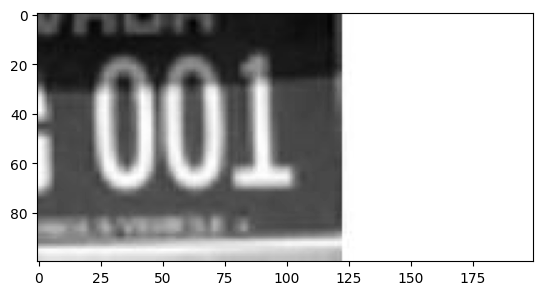

true_label: 001
pred_label: 


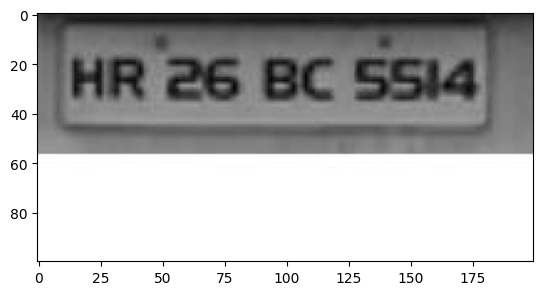

true_label: HR26 BC 5514
pred_label: 


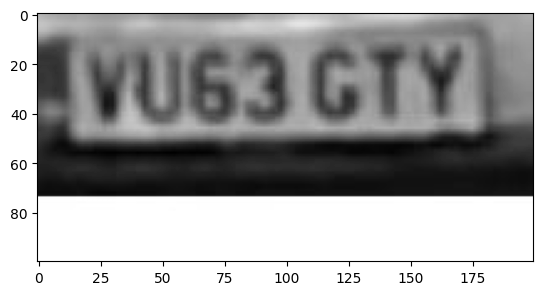

true_label: VU63GTY
pred_label: fvus3cry)



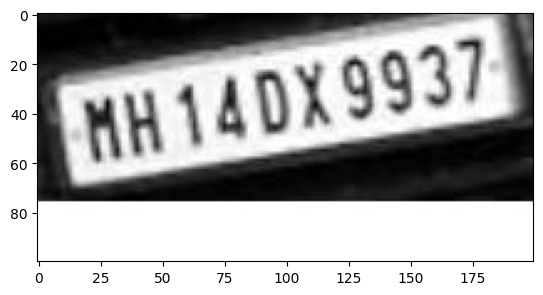

true_label: MH14DX9937
pred_label: WHAui933



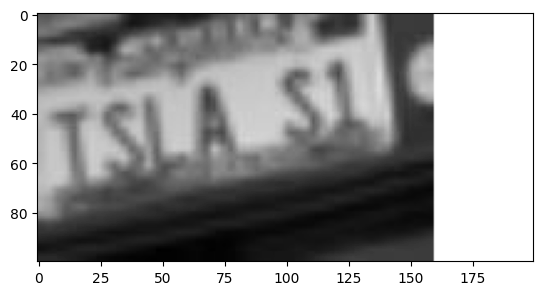

true_label: TSLA S1
pred_label: 


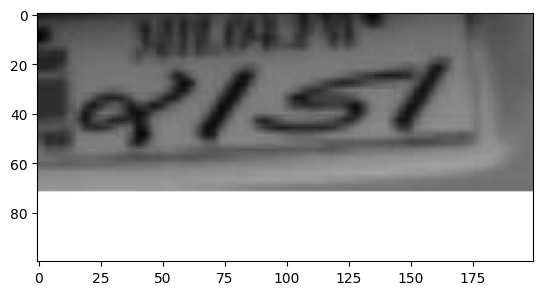

true_label: A151
pred_label: 


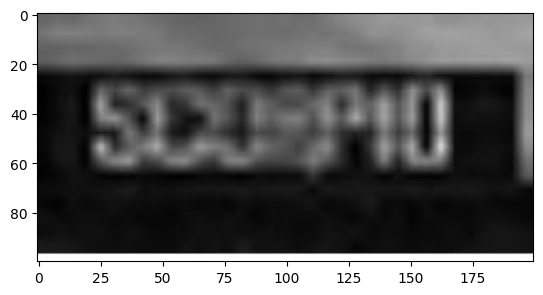

true_label: SCORPIO
pred_label: 


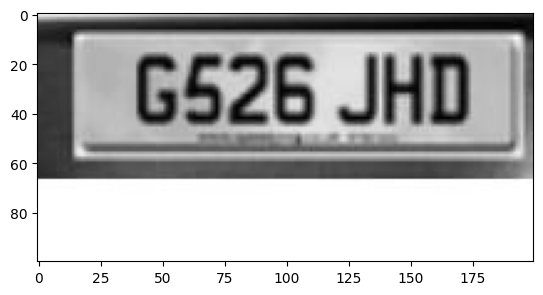

true_label: G526JHD
pred_label: 6526JD|



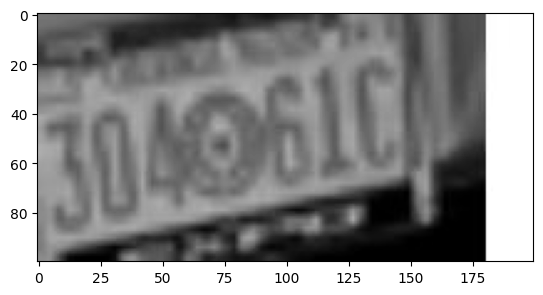

true_label: 304-61C
pred_label: Ooly



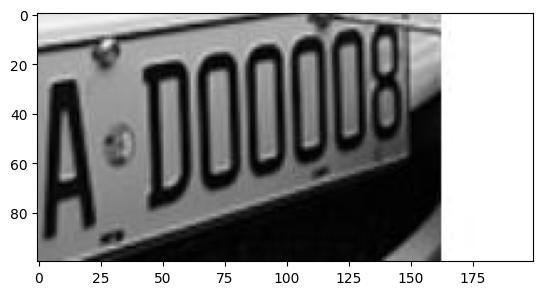

true_label: A-D00008
pred_label: 


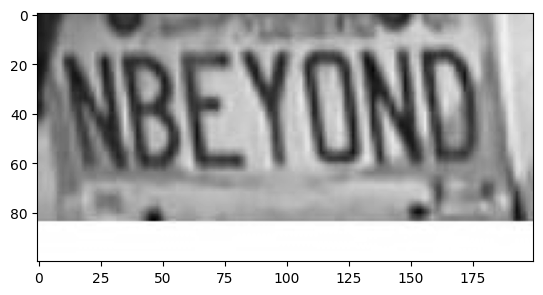

true_label: NBEYOND
pred_label: 


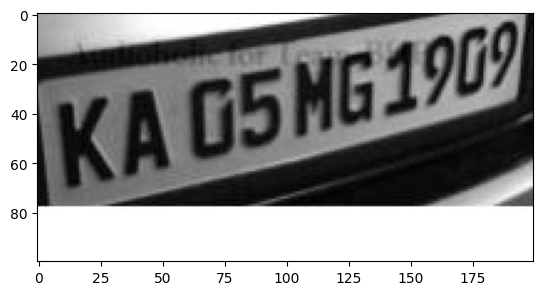

true_label: KA05MG1909
pred_label: 


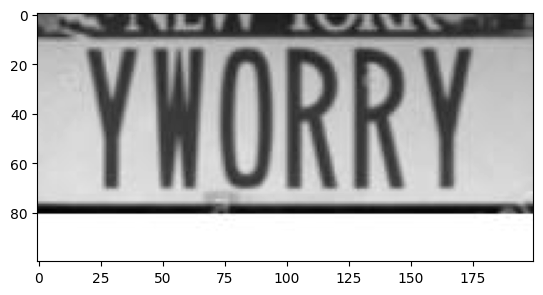

true_label: YWORRY
pred_label: 


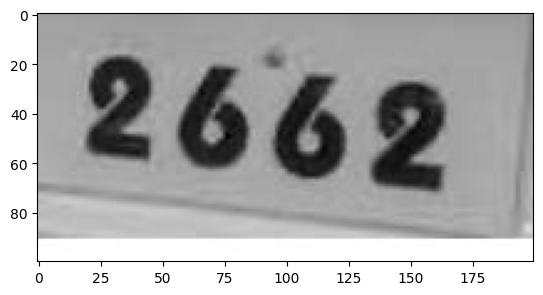

true_label: 2662
pred_label: 2662



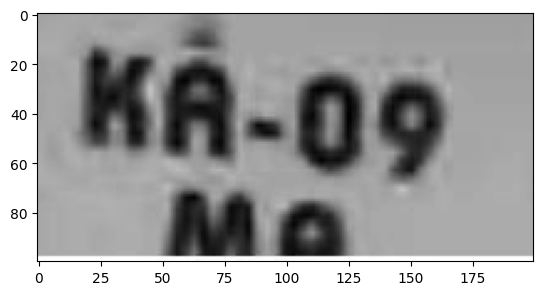

true_label: KA-09
pred_label: 


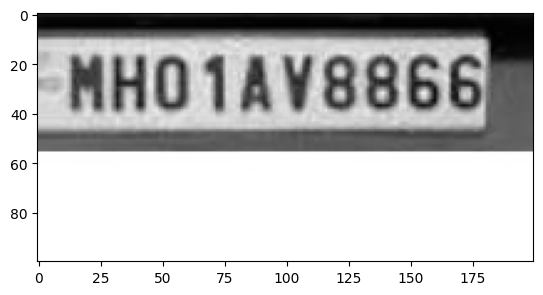

true_label: MH01AV8866
pred_label: HHO1AVS866q



In [ ]:
import pytesseract
from difflib import SequenceMatcher
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

correct_char = 0
total_char = 0
correct = 0

for _, val in test_df.iterrows():
    # Resmi aç ve gri tonlamaya dönüştür
    image = Image.open(val['file_name']).convert("L")
    image = np.array(image)

    # Tesseract OCR kullanarak metni tanı
    pred_label = pytesseract.image_to_string(image).replace(" ", "").replace('-', '-').replace('0', 'O')

    true_label = val['text']

    # Doğru ve tahmin edilen etiketler arasındaki benzerlik oranını hesapla
    correct_char += SequenceMatcher(None, true_label, pred_label).ratio()
    # Toplam karakter sayısını güncelle
    total_char += len(true_label)

    if true_label == pred_label:
        correct += 1
    else:
        plt.imshow(np.asarray(image), cmap='gray')
        plt.show()
        print('true_label:', true_label)
        print('pred_label:', pred_label)


In [ ]:
print(f'correct {correct}, total {len(test_df)}')
print('performance on test  data')
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/len(test_df)))

correct 0, total 42
performance on test  data
Correct characters predicted : 2.74%
Correct words predicted      : 0.00%


In [ ]:
else:
    plt.imshow(np.asarray(image))
    plt.show()
    print('true_label', true_label)
    print('pred_label', pred_label)
